In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Reads the data and show the head of the dataframe
df = pd.read_parquet('./data/2023 DE_case_dataset.gz.parquet', engine='pyarrow')
df.head()

,created,updated,queued,geometric_heuristics,holes,job_run_time,latheability,machining_directions,multipart,neighbors,poles,sheet_like_shape,unmachinable_edges,extrusion_height,units,status,time,uuid
0,2020-02-15 22:46:41,2020-02-15 22:47:00,2020-02-15 22:46:42,"{""unit"":""milliseconds"",""value"":56}",<NA>,"{""unit"":""milliseconds"",""value"":7491}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.84588...","{""box_volume"":{""unit"":""mm3"",""value"":15590.8676...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[8576,6425,3703,762,24,0...",<NA>,<NA>,"{""count"":1469,""edge_list_url"":""s3://3dhubs-pro...",NaN,mm,completed,7547,92fe59e7-eae0-4ba9-bf74-22a82f2c2c83
1,2020-05-13 14:17:10,2020-05-13 14:17:11,2020-05-13 14:17:10,"{""unit"":""milliseconds"",""value"":44}",<NA>,"{""unit"":""milliseconds"",""value"":1143}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.84486...","{""box_volume"":{""unit"":""mm3"",""value"":6241.536},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[374,4058,0,0,28,68,0]}",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1187,0dd8b940-6b35-4ed5-a981-ce05e0734b4f
2,2022-02-16 16:27:18,2022-02-16 16:27:19,2022-02-16 16:27:18,"{""unit"":""milliseconds"",""value"":67}","[{""center"":{""x"":4.254160968e-24,""y"":8.73124980...","{""unit"":""milliseconds"",""value"":1161}","{""axis"":{""x"":0,""y"":1,""z"":0},""fraction"":1,""orig...","{""box_volume"":{""unit"":""mm3"",""value"":10455.28},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[591,2421,2404,1524,1009...",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1228.0,9691095c-d562-4bda-813f-7dbe7398d686
3,2021-05-17 16:42:08,2021-05-17 16:42:10,2021-05-17 16:42:08,"{""unit"":""milliseconds"",""value"":57}","[{""center"":{""x"":0,""y"":0,""z"":28.8500003815},""di...","{""unit"":""milliseconds"",""value"":1910}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.88210...","{""box_volume"":{""unit"":""mm3"",""value"":26218.712}...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[3588,8766,4560,516,780,...","[{""center"":{""x"":-2.782968637e-24,""y"":-2.782968...","{""detected"":false,""positive_fraction_of_sample...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1967,66102ac6-37a3-45b7-97dd-56d02b6ac651
4,2019-11-01 05:34:37,2019-11-01 05:34:43,2019-11-01 05:34:37,"{""unit"":""milliseconds"",""value"":75}",<NA>,"{""unit"":""milliseconds"",""value"":5949}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.93670...","{""box_volume"":{""unit"":""mm3"",""value"":184171.806...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[91270,55336,40349,10925...",<NA>,<NA>,"{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,6024,2c9d084c-dd69-4aff-8b85-a50d0f657372


In [3]:
# Shows the information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   created               20000 non-null  string 
 1   updated               20000 non-null  string 
 2   queued                20000 non-null  string 
 3   geometric_heuristics  19961 non-null  string 
 4   holes                 10211 non-null  string 
 5   job_run_time          19961 non-null  string 
 6   latheability          17503 non-null  string 
 7   machining_directions  19938 non-null  string 
 8   multipart             19938 non-null  string 
 9   neighbors             19938 non-null  string 
 10  poles                 1877 non-null   string 
 11  sheet_like_shape      14685 non-null  string 
 12  unmachinable_edges    19097 non-null  string 
 13  extrusion_height      323 non-null    float64
 14  units                 20000 non-null  string 
 15  status             

In [4]:
def calculate_hole_error(holes):
    """
    Calculates if there is a hole error in the part
    :param holes: holes in the part
    :return: True if there is a hole error, False otherwise
    """
    if pd.isnull(holes):
        return pd.NA
    is_hole_error = False
    holes = json.loads(holes)
    for i in range(len(holes)):
        if holes[i]['length'] > holes[i]['radius'] * 2 * 40:
            is_hole_error = True
            break
    return is_hole_error

In [5]:
def calculate_hole_warning(holes):
    """
    Calculates if there is a hole warning in the part
    :param holes: holes in the part
    :return: True if there is a hole warning, False otherwise
    """
    if pd.isnull(holes):
        return pd.NA
    is_hole_warning = False
    holes = json.loads(holes)
    for i in range(len(holes)):
        if holes[i]['length'] > holes[i]['radius'] * 2 * 10:
            is_hole_warning = True
            break
    return is_hole_warning

In [6]:
# Creates the new columns and calculate if there is a hole error or warning
df['has_unreachable_hole_error'] = df['holes'].apply(lambda x: calculate_hole_error(x))
df['has_unreachable_hole_warning'] = df['holes'].apply(lambda x: calculate_hole_warning(x))

In [7]:
# Shows the head of the dataframe
df.head()

,created,updated,queued,geometric_heuristics,holes,job_run_time,latheability,machining_directions,multipart,neighbors,poles,sheet_like_shape,unmachinable_edges,extrusion_height,units,status,time,uuid,has_unreachable_hole_error,has_unreachable_hole_warning
0,2020-02-15 22:46:41,2020-02-15 22:47:00,2020-02-15 22:46:42,"{""unit"":""milliseconds"",""value"":56}",<NA>,"{""unit"":""milliseconds"",""value"":7491}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.84588...","{""box_volume"":{""unit"":""mm3"",""value"":15590.8676...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[8576,6425,3703,762,24,0...",<NA>,<NA>,"{""count"":1469,""edge_list_url"":""s3://3dhubs-pro...",NaN,mm,completed,7547,92fe59e7-eae0-4ba9-bf74-22a82f2c2c83,<NA>,<NA>
1,2020-05-13 14:17:10,2020-05-13 14:17:11,2020-05-13 14:17:10,"{""unit"":""milliseconds"",""value"":44}",<NA>,"{""unit"":""milliseconds"",""value"":1143}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.84486...","{""box_volume"":{""unit"":""mm3"",""value"":6241.536},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[374,4058,0,0,28,68,0]}",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1187,0dd8b940-6b35-4ed5-a981-ce05e0734b4f,<NA>,<NA>
2,2022-02-16 16:27:18,2022-02-16 16:27:19,2022-02-16 16:27:18,"{""unit"":""milliseconds"",""value"":67}","[{""center"":{""x"":4.254160968e-24,""y"":8.73124980...","{""unit"":""milliseconds"",""value"":1161}","{""axis"":{""x"":0,""y"":1,""z"":0},""fraction"":1,""orig...","{""box_volume"":{""unit"":""mm3"",""value"":10455.28},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[591,2421,2404,1524,1009...",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1228.0,9691095c-d562-4bda-813f-7dbe7398d686,False,False
3,2021-05-17 16:42:08,2021-05-17 16:42:10,2021-05-17 16:42:08,"{""unit"":""milliseconds"",""value"":57}","[{""center"":{""x"":0,""y"":0,""z"":28.8500003815},""di...","{""unit"":""milliseconds"",""value"":1910}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.88210...","{""box_volume"":{""unit"":""mm3"",""value"":26218.712}...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[3588,8766,4560,516,780,...","[{""center"":{""x"":-2.782968637e-24,""y"":-2.782968...","{""detected"":false,""positive_fraction_of_sample...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1967,66102ac6-37a3-45b7-97dd-56d02b6ac651,False,False
4,2019-11-01 05:34:37,2019-11-01 05:34:43,2019-11-01 05:34:37,"{""unit"":""milliseconds"",""value"":75}",<NA>,"{""unit"":""milliseconds"",""value"":5949}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.93670...","{""box_volume"":{""unit"":""mm3"",""value"":184171.806...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[91270,55336,40349,10925...",<NA>,<NA>,"{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,6024,2c9d084c-dd69-4aff-8b85-a50d0f657372,<NA>,<NA>


In [8]:
# Moves the has_unreachable_hole_error and has_unreachable_hole_warning columns next to holes column
# to make it easier to read
cols = df.columns.tolist()
cols = (cols[:cols.index('holes')+1] + 
       cols[cols.index('has_unreachable_hole_error'):cols.index('has_unreachable_hole_warning')+1] + 
       cols[cols.index('holes')+1:-2])
df_ordered = df[cols]
df_ordered.head()

,created,updated,queued,geometric_heuristics,holes,has_unreachable_hole_error,has_unreachable_hole_warning,job_run_time,latheability,machining_directions,multipart,neighbors,poles,sheet_like_shape,unmachinable_edges,extrusion_height,units,status,time,uuid
0,2020-02-15 22:46:41,2020-02-15 22:47:00,2020-02-15 22:46:42,"{""unit"":""milliseconds"",""value"":56}",<NA>,<NA>,<NA>,"{""unit"":""milliseconds"",""value"":7491}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.84588...","{""box_volume"":{""unit"":""mm3"",""value"":15590.8676...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[8576,6425,3703,762,24,0...",<NA>,<NA>,"{""count"":1469,""edge_list_url"":""s3://3dhubs-pro...",NaN,mm,completed,7547,92fe59e7-eae0-4ba9-bf74-22a82f2c2c83
1,2020-05-13 14:17:10,2020-05-13 14:17:11,2020-05-13 14:17:10,"{""unit"":""milliseconds"",""value"":44}",<NA>,<NA>,<NA>,"{""unit"":""milliseconds"",""value"":1143}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.84486...","{""box_volume"":{""unit"":""mm3"",""value"":6241.536},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[374,4058,0,0,28,68,0]}",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1187,0dd8b940-6b35-4ed5-a981-ce05e0734b4f
2,2022-02-16 16:27:18,2022-02-16 16:27:19,2022-02-16 16:27:18,"{""unit"":""milliseconds"",""value"":67}","[{""center"":{""x"":4.254160968e-24,""y"":8.73124980...",False,False,"{""unit"":""milliseconds"",""value"":1161}","{""axis"":{""x"":0,""y"":1,""z"":0},""fraction"":1,""orig...","{""box_volume"":{""unit"":""mm3"",""value"":10455.28},...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[591,2421,2404,1524,1009...",<NA>,"{""detected"":true,""positive_fraction_of_samples...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1228.0,9691095c-d562-4bda-813f-7dbe7398d686
3,2021-05-17 16:42:08,2021-05-17 16:42:10,2021-05-17 16:42:08,"{""unit"":""milliseconds"",""value"":57}","[{""center"":{""x"":0,""y"":0,""z"":28.8500003815},""di...",False,False,"{""unit"":""milliseconds"",""value"":1910}","{""axis"":{""x"":0,""y"":0,""z"":1},""fraction"":0.88210...","{""box_volume"":{""unit"":""mm3"",""value"":26218.712}...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[3588,8766,4560,516,780,...","[{""center"":{""x"":-2.782968637e-24,""y"":-2.782968...","{""detected"":false,""positive_fraction_of_sample...","{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,1967,66102ac6-37a3-45b7-97dd-56d02b6ac651
4,2019-11-01 05:34:37,2019-11-01 05:34:43,2019-11-01 05:34:37,"{""unit"":""milliseconds"",""value"":75}",<NA>,<NA>,<NA>,"{""unit"":""milliseconds"",""value"":5949}","{""axis"":{""x"":1,""y"":0,""z"":0},""fraction"":0.93670...","{""box_volume"":{""unit"":""mm3"",""value"":184171.806...","{""multibody"":false,""patches"":{""count"":1,""not_t...","{""unit"":""mm3"",""value"":[91270,55336,40349,10925...",<NA>,<NA>,"{""count"":0,""edge_list_url"":""s3://3dhubs-produc...",NaN,mm,completed,6024,2c9d084c-dd69-4aff-8b85-a50d0f657372


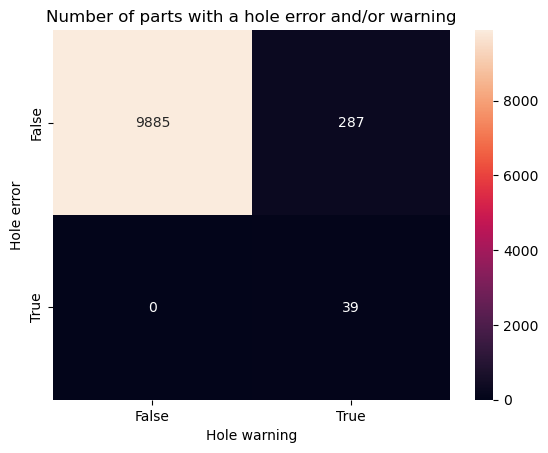

In [9]:
# Shows the information about the hole error and/or warnings
df_plot = df.groupby(['has_unreachable_hole_error', 'has_unreachable_hole_warning']).size().reset_index(name='count')
df_plot = df_plot.pivot(index='has_unreachable_hole_error', columns='has_unreachable_hole_warning', values='count')
df_plot = df_plot.fillna(0)
df_plot = df_plot.astype(int)
# Plots the values in a heatmap
sns.heatmap(df_plot, annot=True, fmt='d')
plt.title('Number of parts with a hole error and/or warning')
plt.xlabel('Hole warning')
plt.ylabel('Hole error')
plt.show()

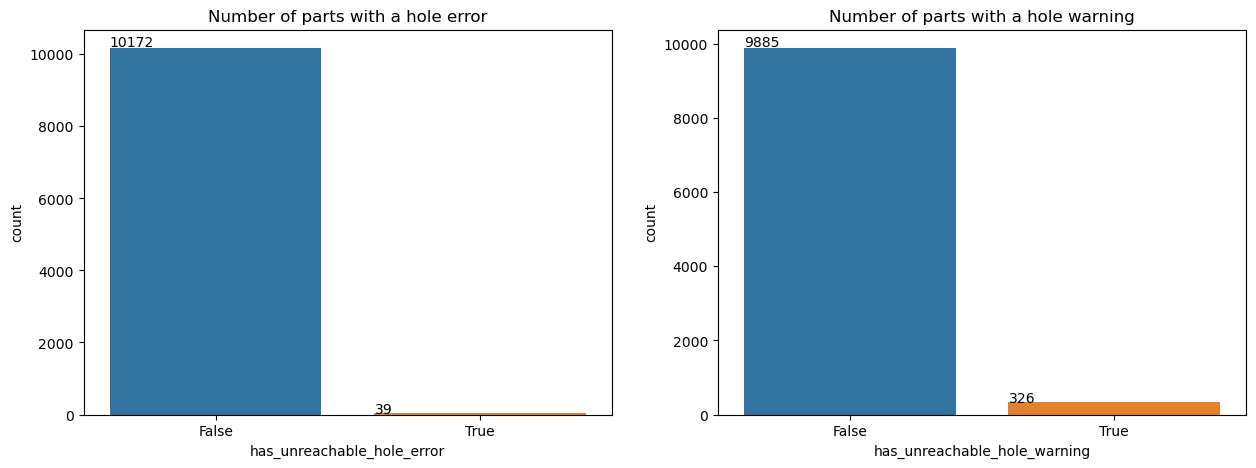

In [10]:
# Plots the number of parts with a hole error and warning individually
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], x='has_unreachable_hole_error', data=df)
sns.countplot(ax=axes[1], x='has_unreachable_hole_warning', data=df)
axes[0].set_title('Number of parts with a hole error')
axes[1].set_title('Number of parts with a hole warning')
# Shows the exact count of the values as mentioned on StackOverflow
for i in range(2):
    for p in axes[i].patches:
        axes[i].annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [11]:
# Saves the dataframe to a new parquet file
df_ordered.to_parquet('./data/2023 DE_case_dataset_holes_error_warning.gz.parquet', engine='pyarrow', compression='gzip')